# Kalman filtering 1.

## Brief history

* Rudolf Emil Kalman (1930-[2016](https://en.wikipedia.org/wiki/Rudolf_E._K%C3%A1lm%C3%A1n)) American electrical engineer and mathematician, born in Hungary, publishes his theory (1960) <img src="REK.jpg" width="180">
* First application: unmanned Lunar mission (1963)
* Applications in navigation and engineering
* Sensor fusion (radar, laser scanner, camera, INS,…)
* Integral part of GNSS receivers, smartphones, computers, games, etc.
* Forecasting stock prices, time series analysis, approximation of functions

The original [publication](https://www.cs.unc.edu/~welch/kalman/media/pdf/Kalman1960.pdf) received more than 30 thousand citations. Let's have a look at it:
<img src="KalmanP.png" width="680">

## Do you understand?

Kalman filter filter yields the exact conditional probability estimate in the special case that all errors are Gaussian. The underlying model is similar to a hidden Markov model except that the state space of the latent variables is continuous and all latent and observed variables have Gaussian distributions.

The above definition is correct but does not make it understand for most of us **what** Kalman filter really is. To understand it, we will consider its properties one after the other:

* recursive
* optimal
* makes estimation of indirect (hidden) state

Finally, Kalman filter equations will be derived which may be easier to grasp from geodetic perspective and discuss a simple navigational example to show how Kalman filter works.

## Recursive estimation

A very simple example is measurement of the state $x$ (which is a scalar variable) of a system at the epochs $t_1, t_2, ... , t_n$. 

Our measrurements are $x_1, x_2, ... , x_n$.

The best state estimate (assuming Gaussian distribution) in this case is the well-known arithmetic mean or *average*:

$$ \mu_n = \frac{1}{n} \sum_{i=1}^n x_i.$$

Suppose we have a new measurement $x_{n+1}$, and our goal is to calculate a new state estimate by using this new measurement. This is the average based on $n+1$ measurements:

$$ \mu_{n+1} = \frac{1}{n+1} \sum_{i=1}^{n+1} x_i.$$

A much more efficient calculation is to "update" our previous average $\mu_n$ by using our new measurement:

$$ \mu_{n+1} = \frac{n}{n+1} \left( \frac{1}{n} \sum_{i=1}^n x_i +  \frac{1}{n} x_{n+1} \right) = \frac{n}{n+1}\mu_n +  \frac{1}{n} x_{n+1}.$$

Our calculator's `STAT` function works similarly: it "updates" the average at each step by using the input data at each step. This is a *recursive estimation*: estimation is updated after getting more data. In our example recursive state estimation can be written in a slightly different form:

$$\mu_{n+1} = \frac{n}{n+1}\mu_n +  \frac{1}{n} x_{n+1} = \mu_n + K(x_{n+1} - \mu_n),$$

where 

$$K = \frac{1}{n+1}$$

denotes *gain*, which tells us the correction to the previous average $\mu_n$, and

$$x_{n+1} - \mu_n,$$

is *innovation* (i.e. new information), since it decides whether our previous estimate changes at all. For when the new measurement $x_{n+1}$ and the previous average $\mu_n$ are the same, our estimate does not change at all.

Let us have a numerical example:

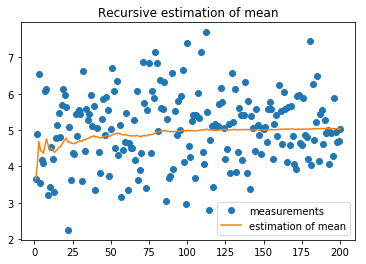

In [2]:
import numpy as np
import matplotlib.pyplot as plt

""" Kalman filter: recursive estimation of mean
"""

npt = 200
x = 5 + np.random.randn(npt)
n = np.arange(1,npt+1)
K = 1.0/(n+1)
mu = np.zeros((npt))
mu[0] = x[0]

for i in range(1,npt):
    mu[i] = mu[i-1] + K[i]*(x[i]-mu[i-1])

plt.plot(n,x,'o',label=u'measurements')
plt.plot(n,mu,label=u'estimation of mean')
plt.legend()
plt.title(u'Recursive estimation of mean')
plt.show()

This example showed an important feature of the Kalman filter: it provides **recursive estimates** of the system state in terms of measurements.

Next let us consider another important feature of the Kalman filter: it provides *best* estimates.

## Best estimates

Suppose $x$ is measured with *two different tools* (e.g. when $x$ is a distance, it is measured both with a measuring tape and with a laser distance meter). Our first tool provides the measurement $x_1$, our second $x_2$. These tools do not have the same precision. Their precisions can be expressed by the standard deviations (mean errors) $\sigma_1$ and $\sigma_2$.

Our goal is to provide *best* estimate of $x$ in terms of measurements $x_1$, $x_2$ and their standard deviations $\sigma_1$,  $\sigma_2$. Let us express this as a *weighted average* of the two measurements:

$$\hat{x} = wx_1 + (1-w)x_2.$$

Our problem is now what weight $w$ makes standard deviation  $\hat\sigma$ of the estimate $\hat{x}$ minimal? 

Since we suppose *Gaussian distribution* of both $x_1$ and $x_2$, according to a [well-known result](https://www.statlect.com/probability-distributions/normal-distribution-linear-combinations) in probability their linear combination is Gaussian as well with variance 

$$\hat\sigma^2 = w^2\sigma_1^2 + (1-w)^2 \sigma_2^2.$$

The best (optimal) weight $w_{opt}$ is that minimizes the above expression, i.e. where the derivative with respect to $w$ is zero:

$$\frac{\partial \hat\sigma^2}{\partial w} = 2w_{opt}\sigma_1^2-2(1-w_{opt})\sigma_2^2 = 0.$$

The optimal weight is

$$ w_{opt} = \frac{\sigma_2^2}{\sigma_1^2+\sigma_2^2}.$$

Optimal estimate $\hat{x}$ of $x$ is:

$$ \hat{x} = \frac{\sigma_2^2}{\sigma_1^2+\sigma_2^2} x_1 + \frac{\sigma_1^2}{\sigma_1^2+\sigma_2^2} x_2.$$

Variance of the optimal estimate is:

$$ \hat\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}.$$

For us in geodesy this is the well-known weighted least squares estimation, since $\hat{x}$ minimizes the sum of weighted residuals:

$$\hat{x} =  \underset{x}{\arg \min} = \left[ p_1 (x_1 - x)^2 + p_2 (x_2 - x)^2 \right],$$

where $p_1$, $p_2$ denotes weights proportional to reciprocal variances. In fact if we make derivative of the above expression with respect to $x$ and make it equal to zero the equation 

$$ p_1(x_1-\hat{x}) + p_2(x_2-\hat{x}) = 0$$

is yielded. Its solution for $\hat{x}$ is

$$ \hat{x} = \frac{1}{p_1+p_2}(p_1 x_1 + p_2 x_2)$$

which is identical with the previous solution when $p_1=1/\sigma_1^2$ and  $p_2=1/\sigma_2^2$.

## Recursive best estimate

Let us recast our best estimate in the following way: first we use measurement $x_1$ for estimation, then update (correct) our estimate by using the next measurement $x_2$. Obviously in the first step $\hat{x_1} = x_1$, $\hat\sigma_1^2=\sigma_1^2$, where subscript refers to the step. In the second step we update our estimate as

$$\hat{x}_2 = \hat{x}_1 + \frac{\hat{\sigma}_1^2}{\hat{\sigma}_1^2 + \sigma_2^2} (x_2 - \hat{x}_1),$$

$$\hat{\sigma}_2^2 = \left( 1 - \frac{\hat{\sigma}_1^2}{\hat{\sigma}_1^2 + \sigma_2^2}  \right) \hat{\sigma}_1^2.$$

The factor in parentheses $(x_2 - \hat{x}_1)$ is *innovation* (new information), and its multiplier, 

$$\frac{\hat{\sigma}_1^2}{\hat{\sigma}_1^2 + \sigma_2^2}$$

is the *gain* $K$. Let us summarize our recursive estimation scheme:

$$\hat{x}_2 = \hat{x}_1 + K(x_2 - \hat{x}_1),$$

$$\hat{\sigma}_2^2 = ( 1 - K ) \hat{\sigma}_1^2,$$

$$K = \frac{\hat{\sigma}_1^2}{\hat{\sigma}_1^2 + \sigma_2^2}.$$

As we can see it has the same form as our previous recursive estimate

$$\mu_{n+1} = \mu_n + K(x_{n+1} - \mu_n),$$

but now we have found the *best* (optimal) value of the gain $K$ that minimizes estimation variance. This best estimate can always be updated when a new measurement is available.

At this point we remark that if state $x$ is not a scalar but a vector $\mathbf{x} = (x_1, x_2, ...)$, the procedure is the same, but we must use covariance matrices instead of variances. Among others, we will form inverses of covariance matrices instead of reciprocals of variances.

## Indirect state estimation

Until now it was supposed that we can *directly* measure the system state $x$. In most cases this cannot be made - only a quantity $\mathbf{z}$ can be measured, which is related to the system's state $x$. This problem is well-known in geodesy: least squares adjustment with parameters. A similar problem is solved by the Kalman filter: estimation of unobservable (hidden) system states with measurements. 

First we deal with *static* systems, the state of those do not change with time. But we do have a key assumption for both static and dynamic systems: system state $\mathbf{x}$ is connected with measured $\mathbf{z}$ with a **linear** model:

$$ \mathbf{z} = \mathbf{H} \mathbf{x} + \mathbf{r}.$$

In this equation matrix $\mathbf{H}$ is the measurement model (the well-known design matrix), moreover measurement residuals $\mathbf{r}$ are zero mean ($\bar{\mathbf{r}}=\mathbf{0}$) and Gaussian distributed. These residuals (noise) have noise *covariance matrix* $\mathbf{R}$ 

$$ \mathbf{R} = \mathbb{E}\left[ (\mathbf{r} - \bar{\mathbf{r}}) (\mathbf{r} - \bar{\mathbf{r}})^T  \right]$$

where $\mathbb{E}[.]$ denotes expectation value. We want best (optimal) estimation $\hat{\mathbf{x}}$ of the system state that minimizes measurement residuals (noise) weighted by the inverse covariance matrix. This is the very well known adjustment with parameters (now system state $\mathbf{x}$ are the parameters), where weight matrix $\mathbf{P}$ is proportional with inverse $\mathbf{R}^{-1}$ of the noise covariance matrix.

<u>**Recursive estimation**</u>

In contrast with traditional adjustment with parameters let us suppose a continuous flow of measurements, i.e. they are not available at once. At each measurement epoch $k$ a new measurement $\mathbf{z}_k$ is available and we need best estimates of the state $\hat{\mathbf{x}}_k$ and state covariance matrix $\hat{\mathbf{P}}_k$. Our minimization problem is therefore:

$$\hat{\mathbf{x}}_k =  \underset{x}{\arg \min} = \left[ (\mathbf{z}_k-\mathbf{H}_k \mathbf{x})^T \mathbf{R}_k^{-1} (\mathbf{z}_k-\mathbf{H}_k \mathbf{x}) \right].$$

*Static Kalman filter* provides solution to this minimization problem. It provides new estimate $\hat{\mathbf{x}}_k$ and its covariance matrix $\hat{\mathbf{P}}_k$ from previous estimates $\hat{\mathbf{x}}_{k-1}$, $\hat{\mathbf{P}}_{k-1}$ and measurement $\mathbf{z}_k$ and its covariance matrix $\mathbf{R}_k$. 

A typical example of static Kalman filtering would be position estimation of a static GNSS receiver. In this case the hidden system state (parameter vector $\mathbf{x}$) contains unkonwn position and clock bias of the receiver. Measurements $\mathbf{z}$ are the satellite-receiver pseudoranges. When all measurements are available this is a problem in traditional least squares estimation. When there is a continuous flow of measurements epoch by epoch, the positioning requires recursive least squares adjustment, i.e. static Kalman filtering.

Next we derive equations of the static Kalman filter by *adjustment in groups* used in geodesy. It will be recognized that equations of the static Kalman filter are identical with that of parametric adjustment in groups.


## Equations of the static Kalman filter

This derivation follows that of Section 5.8.2 found in textbook of Detrekői: Adjustment calculations (Kiegyenlítő számítások, in Hungarian). Our notation, however, will be more close to the notation used in Kalman filtering literature, to ease comparision of the two procedures. We restrict our attention to the linear case, hence no linearization of equations for the parameters is required.

Within the procedure for adjustment in groups there are measurements at different epochs and measurements at a later epoch are processed by using results obtained from previous epochs. Let us asume that at epoch $i=1$ by using $n$ measurements $\mathbf{z}_1$, adjusted parameters $\mathbf{x}_1$ and their covariance matrix $\mathbf{P}_{11}$ have already been determined by using the covariance matrix $\mathbf{R}_{11}$ of measurements from linear measurement (residual) equations 

$$ \mathbf{r}_1 = \mathbf{z}_1 - \mathbf{H}_1\mathbf{x}_1 $$

through the normal equations

$$ \mathbf{N}_1 \mathbf{x}_1 - \mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{z}_1 = \mathbf{0}.$$

If the coefficient matrix $ \mathbf{N}_1= \mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{H}_1$ of the normal equations is nonsingular, then the unknown parameters are

$$\mathbf{x}_1 = \mathbf{N}_1^{-1}\mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{z}_1 .$$

Covariance matrix of estimated parameters is

$$ \mathbf{P}_{11} = \mathbf{N}_1^{-1} =  (\mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{H}_1)^{-1}.$$

In the next epoch $i+1=2$ additional $s$ measurements $\mathbf{z}_2$ are made, their covariance matrix is $\mathbf{R}_{22}$. Let us assume that these measurements are independent of the measurements at the previous epoch. Let us calculate the updated parameter vector $\mathbf{x}_2$, updated measurement residual vector $\mathbf{r}_r$ and the covariance matrix $\mathbf{P}_{22}$ of the updated parameter vector.

Updated normal equation is

$$ (\mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{H}_1 + \mathbf{H}_2^T\mathbf{R}_{22}^{-1}\mathbf{H}_2)\mathbf{x}_2 - ( \mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{z}_1 + \mathbf{H}_2^T\mathbf{R}_{22}^{-1}\mathbf{z}_2) = \mathbf{0}.$$

Let us introduce a size $s$ new parameter $\mathbf{y}$ vector:

$$ \mathbf{y}= \mathbf{R}_{22}^{-1}\mathbf{r}_2 = \mathbf{R}_{22}^{-1}\mathbf{z}_2 -\mathbf{R}_{22}^{-1}\mathbf{H}_2  \mathbf{x}_2 .$$

Then, with the help of  $\mathbf{y}$, the equation of residuals

$$ \mathbf{r}_2 = \mathbf{z}_2 - \mathbf{H}_2\mathbf{x}_2 $$

can be transformed into a parametric constraint equation:

$$ \mathbf{R}_{22}\mathbf{y}= \mathbf{z}_2 - \mathbf{H}_2\mathbf{x}_2,$$

from which we can derive the usual form of constraint equations:

$$ \mathbf{z}_2 - \mathbf{H}_2\mathbf{x}_2 - \mathbf{R}_{22}\mathbf{y} = \mathbf{0}$$

Using vector $\mathbf{y}$ we transform normal equations:

$$(\mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{H}_1)\mathbf{x}_2 - \mathbf{H}_2^T\mathbf{y} -  \mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{z}_1 = \mathbf{0}$$

Constraint equations together with transformed normal equations lead to the following system of equations with blocks of size $n+s$:

$$\begin{bmatrix} \mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{H}_1 & - \mathbf{H}_2^T \\ - \mathbf{H}_2 & - \mathbf{R}_{22}\end{bmatrix}  \begin{bmatrix} \mathbf{x}_2\\ \mathbf{y}\end{bmatrix} = \begin{bmatrix} \mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{z}_1\\ -\mathbf{z}_2\end{bmatrix}. $$

To solve for $\mathbf{x}_2$ we invert its coefficient matrix $\mathbf{A}$ with blocks by using Gauss-Jordan elimination. Our starting point is the augmented matrix

$$\begin{bmatrix} \mathbf{A} & | &  \mathbf{I} \end{bmatrix} $$

and with Gauss-Jordan elimination we transform it into the form

$$\begin{bmatrix} \mathbf{I} & | &  \mathbf{A}^{-1} \end{bmatrix} $$

where $\mathbf{I}$ denotes identity matrix.

Starting with the augmented matrix (for simplicity of notation $\mathbf{N}=\mathbf{N}_1$)

$$\begin{bmatrix} \mathbf{N} & - \mathbf{H}_2^T & \mathbf{I} & \mathbf{0}  \\ - \mathbf{H}_2 & - \mathbf{R}_{22} & \mathbf{0} & \mathbf{I}\end{bmatrix} $$

we multiply its first row from left with $\mathbf{N}^{-1}$-el, and add to second row first row multiplied from left with $\mathbf{H}$. Since $\mathbf{H}_2\mathbf{I}=\mathbf{H}_2$ if $\mathbf{I}$ is an $r\times r$ identity matrix it yields the augmented matrix

$$\begin{bmatrix} \mathbf{I} & - \mathbf{N}^{-1}\mathbf{H}_2^T & \mathbf{N}^{-1} & \mathbf{0}  \\ \mathbf{0} & - \mathbf{R}_{22}- \mathbf{H}\mathbf{N}^{-1}\mathbf{H}_2^T & \mathbf{H}_2\mathbf{N}^{-1} & \mathbf{I}\end{bmatrix}.$$

Let us introduce the notation $\mathbf{S} = (\mathbf{R}_{22}+ \mathbf{H}\mathbf{N}^{-1}\mathbf{H}_2^T)^{-1}$. If we multiply from left by $-\mathbf{S}$ its second row we get matrix

$$\begin{bmatrix} \mathbf{I} & - \mathbf{N}^{-1}\mathbf{H}_2^T & \mathbf{N}^{-1} & \mathbf{0}  \\ \mathbf{0} & \mathbf{I} & -\mathbf{S}\mathbf{H}_2\mathbf{N}^{-1} & -\mathbf{S}\end{bmatrix}.$$

Finally, add to the first row the second row multiplied from left by  $\mathbf{N}^{-1}\mathbf{H}_2^T$. It yields the augmented matrix

$$\begin{bmatrix} \mathbf{I} & \mathbf{0} & \mathbf{N}^{-1} - \mathbf{N}^{-1}\mathbf{H}_2^T\mathbf{S}\mathbf{H}_2\mathbf{N}^{-1} & -\mathbf{N}^{-1}\mathbf{H}_2^T\mathbf{S}  \\ \mathbf{0} & \mathbf{I} & -\mathbf{S}\mathbf{H}_2\mathbf{N}^{-1} & -\mathbf{S}\end{bmatrix}. $$

On the right side of this matrix there is the inverse that was looked for.


If we multiply with this inverse from left the equation to be solved we find the solution

$$\begin{bmatrix} \mathbf{x}_2\\ \mathbf{y}\end{bmatrix} =  \begin{bmatrix} \mathbf{N}^{-1} - \mathbf{N}^{-1}\mathbf{H}_2^T\mathbf{S}\mathbf{H}_2\mathbf{N}^{-1} & -\mathbf{N}^{-1}\mathbf{H}_2^T\mathbf{S}  \\ -\mathbf{S}\mathbf{H}_2\mathbf{N}^{-1} & -\mathbf{S}\end{bmatrix} \begin{bmatrix} \mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{z}_1\\ -\mathbf{z}_2\end{bmatrix}. $$

In the following, if we use the notation $\mathbf{K} =\mathbf{N}^{-1}\mathbf{H}_2^T\mathbf{S} $ then the solution $\mathbf{x}_2$ is

$$ \mathbf{x}_2 = \mathbf{N}^{-1}\mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{z}_1 - \mathbf{K}\mathbf{H}_2\mathbf{N}^{-1}\mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{z}_1 + \mathbf{K}\mathbf{z}_2.$$

This solution can be simplified by taking into account the relation $\mathbf{x}_1 = \mathbf{N}_1^{-1}\mathbf{H}_1^T\mathbf{R}_{11}^{-1}\mathbf{z}_1 $. Finally we get

$$ \mathbf{x}_2 = \mathbf{x}_1 - \mathbf{K}\mathbf{H}_2\mathbf{x}_1 + \mathbf{K}\mathbf{z}_2 = \mathbf{x}_1 + \mathbf{K}(\mathbf{z}_2 - \mathbf{H}_2\mathbf{x}_1  ).$$


Substituting matrix $\mathbf{S}$ into the equation (since additionally $\mathbf{N}^{-1}=\mathbf{P}_{11}$)

$$ \mathbf{K} = \mathbf{P}_{11}\mathbf{H}_2^T(\mathbf{R}_{22} + \mathbf{H}_2 \mathbf{P}_{11} \mathbf{H}_2^T)^{-1}.$$

Covariance matrix of adjusted parameters is the upper left block of the inverted hypermatrix  (the block belonging to $\mathbf{x}_2$)

$$ \mathbf{P}_{22} = (\mathbf{I} - \mathbf{K}\mathbf{H}_2) \mathbf{P}_{11}.$$

These are identical with the equations of the static Kalman filter. Kalman gain matrix is $\mathbf{K}$, measurement matrix is $\mathbf{H}$, system state is $\mathbf{x}$. The filter updates state estimate and its covariance matrix $\mathbf{P}$ after each new measurement.

Equations of the *dynamic* Kalman filter are slightly different since also system state $ \mathbf{x}$ is variable from epoch $k$ to epoch $k+1$:

$$\mathbf{x}_{k+1} = \mathbf{F}\mathbf{x}_k + \mathbf{B}\mathbf{u}_k + \mathbf{q}$$

where $\mathbf{F}$ denotes state transition matrix, $\mathbf{u}$ is system forcing, $\mathbf{B}$ denotes system control matrix and $\mathbf{q}$ is a zero-mean system noise with covariance matrix $\mathbf{Q}$.

Covariance matrix $\mathbf{P}^-$ after state transition of the dynamical system is simply obtained with the well-known covariance propagation rule:

$$\mathbf{P}^-_k = \mathbf{H} \mathbf{P}_{k-1} \mathbf{H}^T + \mathbf{Q}.$$

## Kalman filter example: vehicle navigation

Consider a vehicle moving along a straight path. Our model of the system (vehicle) state $x$ contains position $p$ and velocity $v$ of the vehicle. System input $u$ are known control accelerations and output $y$ are position measurements. The system is controlled by accelerations and its position is measured at $T$ seconds. Basic kinematics provide the following equation of the velocity $v$:

$$v_{k+1} = v_k + Tu_k.$$

But our model is not yet complete. It is because velocity may have change randomly due to unavoidable external factors. Velocity noise $\tilde{v}_k$ is a time-dependent random variable, hence 

$$v_{k+1} = v_k + Tu_k + \tilde{v}_k$$

is our complete velocity model. A similar equation holds for the position $p$:

$$p_{k+1} = p_k + Tv_k + \frac{1}{2}T^2u_k + \tilde{p}_k,$$

where $\tilde{p}_k$ denotes position uncertainty (noise). State vector contains position and velocity:

$$x_k = \left[ p_k \atop v_k \right].$$

Since we know that $z$ is vehicle's measured position the following system equation can be assembled:

$$x_{k+1} = \begin{bmatrix}1 & T\\0 & 1 \end{bmatrix} x_k + \begin{bmatrix}T^2/2\\T \end{bmatrix} u_k + w_k$$

$$y_k =\begin{bmatrix}1 & 0\end{bmatrix} x_k + \nu_k.$$

Measurement noise $\nu_k$ comes from sensor imperfection. We want best (most accurate) estimates of vehicle's state $x$.

It is relatively straightforward in Kalman filtering to specify measurement noise, in this case to specify covariance "matrix" $R$ (here a scalar only) of position noise, since generally sensor noise is known. Let us specify the standard deviation of position noise in this example as ± 3 m. A more difficult task is to define the covariance matrix $O$ of system noise. For this purpose we apply the so called Discrete White Noise Acceleration model (DWNA). If acceleration noise $w_{acc}$ is known (we specify ± 0.2 m/$\mathrm{s}^2$ for this problem) than covariance matrix of system noise is

$$Q = \begin{bmatrix}¼T^4 & ½T^3\\½T^3 & T^2 \end{bmatrix} w_{acc}^2.$$

The function `kalman(duration,dt)` makes estimation of vehicle's position and speed with Kalman filtering. It makes plot of estimated and measured vehicle positions by simulation. The plot demonstrates well why this process is called filtering.

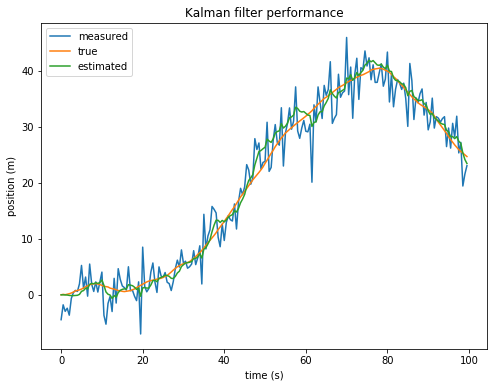

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def kalman(duration, dt, accelnoise = 0.2):
    ## function kalman(duration, dt) - Kalman filter simulation
    ## duration = length of simulation (seconds)
    ## accelnoise = acceleration noise (m/sec**2)
    ## dt = step size (seconds)

    measnoise  = 3     ## position measurement noise (m)

    F = np.array([[1, dt],[0, 1]])  ## state transition matrix
    H = np.array([[1, 0]])            ## measurement matrix
    x = np.array([[0, 0]]).T    ## initial state vector
    xhat = x     ## initial state estimate

    Q = accelnoise**2 * np.array([[dt**4/4, dt**3/2],[dt**3/2, dt**2]])    ## process noise covariance
    P = Q     ## initial estimation covariance
    R = measnoise**2     ## measurement error covariance

    dimt = int(duration/dt)      ## number of epochs
    pos     = np.zeros(dimt)     ## true position array
    poshat  = np.zeros(dimt)     ## estimated position array
    posmeas = np.zeros(dimt)     ## measured position array

    k = 0
    for t in np.arange(0,duration,dt):    
        ## Simulate process
        ProcessNoise = accelnoise * np.array([[(dt**2/2)*np.random.normal(), dt*np.random.normal()]]).T
        x = np.dot(F,x) + ProcessNoise
        ## Simulate measurement z at epoch t
        MeasNoise = measnoise * np.random.normal()    
        z = np.dot(H,x) + MeasNoise    
        ## Innovation: z - H.xh
        Inn = z - np.dot(H,xhat)    
        ## Covariance of Innovation: S = H.P.H' + R
        S = np.dot(np.dot(H,P),H.T) + R    
        ## Gain matrix K = F.P.H'.inv(S)
        K = np.dot(np.dot(np.dot(F,P),H.T),np.linalg.inv(S))
        ## State estimate: xh = F.xh + K.Inn 
        xhat = np.dot(F,xhat) + np.dot(K,Inn)    
        ## Covariance of prediction error: P = F.P.F' + Q - K.H.P.F'
        P = np.dot(np.dot(F,P),F.T) + Q - np.dot(np.dot(np.dot(K,H),P),F.T)    
        ## Save some parameters in vectors for plotting later
        pos[k]     = x[0]    
        posmeas[k] = z    
        poshat[k]  = xhat[0]
        k = k + 1

    return pos,posmeas,poshat   

## Simulate

duration = 100
dt = 0.5
p,pm,phat = kalman(duration,dt)

## Plot the results
t = np.arange(0,duration,dt)
plt.figure(figsize=(8,6))
plt.plot(t,pm,label='measured')
plt.plot(t,p,label='true')
plt.plot(t,phat,label='estimated')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.title('Kalman filter performance')
plt.show()    

This simple example gave a good demonstration of basic Kalman filtering. In practice, however, often we have a nonlinear dependence of measurements on the system state, that cannot be characterized with a measurement matrix $\mathbf{H}$. This will be discussed further and will lead to the Extended Kalman Filter (EKF) and Unscented Kalman Filter (UKF).